# Latent Neural ODEs

We demonstrate how to combine Neural ODEs with variational autoencoders to model irregular time series data. The model learns a low-dimensional latent representation whose dynamics are governed by an ODE.

**Notebook:** [![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-F9AB00?style=flat-square&logo=googlecolab)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/docs/07-neural-ode/latent-ode.ipynb)

**Paper:** [![Latent ODE Paper](https://img.shields.io/badge/View-Paper-red?style=flat-square&logo=adobeacrobatreader&logoColor=white)](https://arxiv.org/abs/1907.03907)

---

## The Model

Given observations $\{x(t_i)\}_{i=1}^N$ at irregular times $t_1, \ldots, t_N$, we:

1. **Encode** observations into latent state $z_0$ using an RNN run backwards in time
2. **Evolve** latent state forward via ODE: $\frac{dz}{dt} = f_\theta(z, t)$  
3. **Decode** latent states $z(t_i)$ to reconstruct observations

The objective is the Evidence Lower Bound (ELBO):
$$\mathcal{L} = \mathbb{E}_{q(z_0|x)}[\log p(x|z)] - D_{KL}(q(z_0|x) \| p(z_0))$$

where $q(z_0|x)$ is the variational posterior from the RNN encoder.

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint

device = torch.device('cpu')

## Data Generation

We generate noisy observations from Archimedean spirals with parametric form $r = a + b\theta$. For each training example, we sample a consecutive window of observations from a random starting point.

In [2]:
def generate_spiral2d(nspiral=1000, ntotal=1000, nsample=100,
                      start=0., stop=6*np.pi, noise_std=0.3, a=0., b=0.3):
    """
    Generate spirals using r = a + b*theta
    
    Returns:
        orig_trajs: (nspiral, ntotal, 2) - full spiral trajectories
        samp_trajs: (nspiral, nsample, 2) - sampled noisy observations  
        orig_ts: (ntotal,) - full timestamps
        samp_ts: (nsample,) - sample timestamps
    """
    orig_ts = np.linspace(start, stop, num=ntotal)
    samp_ts = orig_ts[:nsample]
    
    # Clockwise spiral
    zs_cw = stop + 1. - orig_ts
    rs_cw = a + b * 50. / zs_cw
    xs_cw = rs_cw * np.cos(zs_cw) - 5.
    ys_cw = rs_cw * np.sin(zs_cw)
    orig_traj_cw = np.stack((xs_cw, ys_cw), axis=1)
    
    # Counter-clockwise spiral
    zs_cc = orig_ts
    rs_cc = a + b * zs_cc
    xs_cc = rs_cc * np.cos(zs_cc) + 5.
    ys_cc = rs_cc * np.sin(zs_cc)
    orig_traj_cc = np.stack((xs_cc, ys_cc), axis=1)
    
    # Sample consecutive windows from random starting points
    orig_trajs = []
    samp_trajs = []
    for _ in range(nspiral):
        # Random starting index, avoiding boundaries
        t0_idx = npr.multinomial(1, [1./(ntotal - 2.*nsample)] * (ntotal - int(2*nsample)))
        t0_idx = np.argmax(t0_idx) + nsample
        
        # Random rotation direction
        cc = bool(npr.rand() > 0.5)
        orig_traj = orig_traj_cc if cc else orig_traj_cw
        orig_trajs.append(orig_traj)
        
        # Consecutive window with noise
        samp_traj = orig_traj[t0_idx:t0_idx + nsample, :].copy()
        samp_traj += npr.randn(*samp_traj.shape) * noise_std
        samp_trajs.append(samp_traj)
    
    orig_trajs = np.stack(orig_trajs, axis=0)
    samp_trajs = np.stack(samp_trajs, axis=0)
    
    return orig_trajs, samp_trajs, orig_ts, samp_ts

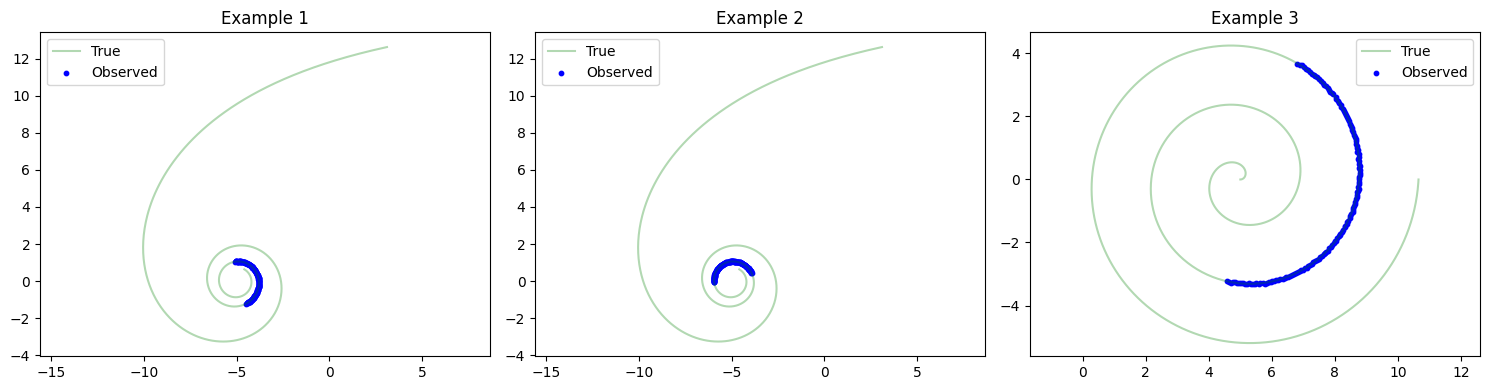

In [3]:
# Generate data
npr.seed(0)
nspiral = 1000
ntotal = 1000
nsample = 150
noise_std = 0.01

orig_trajs, samp_trajs, orig_ts, samp_ts = generate_spiral2d(
    nspiral=nspiral, ntotal=ntotal, nsample=nsample, noise_std=noise_std
)

# Visualize a few examples
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, ax in enumerate(axes):
    ax.plot(orig_trajs[i, :, 0], orig_trajs[i, :, 1], 'g-', alpha=0.3, label='True')
    ax.scatter(samp_trajs[i, :, 0], samp_trajs[i, :, 1], s=10, c='b', label='Observed')
    ax.set_title(f'Example {i+1}')
    ax.legend()
    ax.axis('equal')
plt.tight_layout()
plt.savefig('figs/latent_ode_data.png', dpi=150, bbox_inches='tight')
plt.show()

# Convert to tensors
orig_trajs = torch.from_numpy(orig_trajs).float().to(device)
samp_trajs = torch.from_numpy(samp_trajs).float().to(device)
samp_ts = torch.from_numpy(samp_ts).float().to(device)

## Model Architecture

The model has three components:

1. **Recognition RNN**: Processes observations backwards in time to produce $q(z_0|x) = \mathcal{N}(\mu, \sigma^2)$
2. **ODE Function**: Defines latent dynamics $f_\theta(z,t)$ via a 3-layer MLP
3. **Decoder**: Maps latent states to observations via a 2-layer MLP

In [4]:
class LatentODEfunc(nn.Module):
    def __init__(self, latent_dim=4, nhidden=20):
        super().__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)
        self.nfe = 0
    
    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        return out


class RecognitionRNN(nn.Module):
    def __init__(self, latent_dim=4, obs_dim=2, nhidden=25, nbatch=1):
        super().__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.h2o = nn.Linear(nhidden, latent_dim * 2)
    
    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1)
        h = torch.tanh(self.i2h(combined))
        out = self.h2o(h)
        return out, h
    
    def initHidden(self):
        return torch.zeros(self.nbatch, self.nhidden)


class Decoder(nn.Module):
    def __init__(self, latent_dim=4, obs_dim=2, nhidden=20):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)
    
    def forward(self, z):
        out = self.fc1(z)
        out = self.relu(out)
        out = self.fc2(out)
        return out

## Loss Function

The ELBO loss has two terms:

1. **Reconstruction**: Log-likelihood $\log p(x|z) = \sum_i \log \mathcal{N}(x_i | \hat{x}_i, \sigma^2)$
2. **Regularization**: KL divergence $D_{KL}(q(z_0) \| p(z_0))$ between variational posterior and standard normal prior

In [5]:
def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float().to(x.device)
    const = torch.log(const)
    return -0.5 * (const + logvar + (x - mean)**2 / torch.exp(logvar))


def normal_kl(mu1, lv1, mu2, lv2):
    """KL divergence between two Gaussians (closed form)"""
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.
    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2)**2) / (2. * v2)) - 0.5
    return kl

## Training

In [6]:
# Model hyperparameters
latent_dim = 4
nhidden = 20
rnn_nhidden = 25
obs_dim = 2

# Training hyperparameters
niters = 1500
lr = 0.01

# Initialize models
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nspiral).to(device)
dec = Decoder(latent_dim, obs_dim, nhidden).to(device)

params = list(func.parameters()) + list(dec.parameters()) + list(rec.parameters())
optimizer = optim.Adam(params, lr=lr)

# Training loop
losses = []
for itr in range(1, niters + 1):
    optimizer.zero_grad()
    
    # Encode: run RNN backwards to infer q(z_0)
    h = rec.initHidden().to(device)
    for t in reversed(range(samp_trajs.size(1))):
        obs = samp_trajs[:, t, :]
        out, h = rec.forward(obs, h)
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    
    # Reparameterization trick
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(0.5 * qz0_logvar) + qz0_mean
    
    # Evolve: solve ODE forward in time
    pred_z = odeint(func, z0, samp_ts).permute(1, 0, 2)
    
    # Decode: map latent to observations
    pred_x = dec(pred_z)
    
    # Compute ELBO loss
    noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
    noise_logvar = 2. * torch.log(noise_std_).to(device)
    logpx = log_normal_pdf(samp_trajs, pred_x, noise_logvar).sum(-1).sum(-1)
    
    pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
    analytic_kl = normal_kl(qz0_mean, qz0_logvar, pz0_mean, pz0_logvar).sum(-1)
    
    loss = torch.mean(-logpx + analytic_kl, dim=0)
    
    loss.backward()
    optimizer.step()
    
    losses.append(-loss.item())
    
    if itr % 100 == 0:
        print(f'Iter {itr}: ELBO={-loss.item():.1f}')

Iter 100: ELBO=-3015468.5
Iter 200: ELBO=-161320.5
Iter 300: ELBO=-51049.0
Iter 400: ELBO=-34965.7
Iter 500: ELBO=-20377.4
Iter 600: ELBO=-13986.6
Iter 700: ELBO=-12029.9
Iter 800: ELBO=-33337.6
Iter 900: ELBO=-10824.6
Iter 1000: ELBO=-10957.5
Iter 1100: ELBO=-49320.6
Iter 1200: ELBO=-7010.9
Iter 1300: ELBO=-4493.4
Iter 1400: ELBO=-62777.1
Iter 1500: ELBO=-4326.7


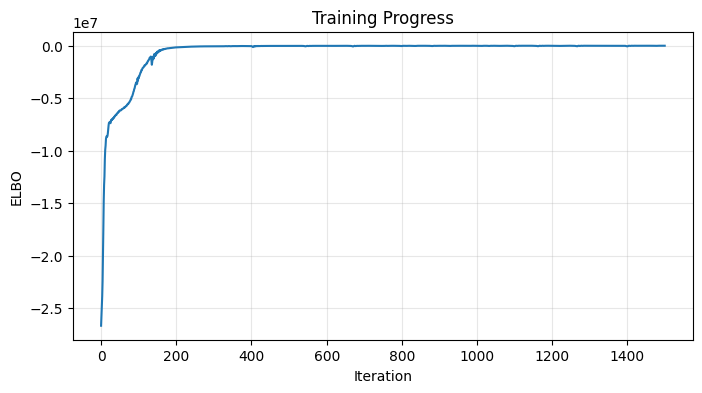

In [7]:
# Plot training curve
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('ELBO')
plt.title('Training Progress')
plt.grid(True, alpha=0.3)
plt.savefig('figs/latent_ode_training.png', dpi=150, bbox_inches='tight')
plt.show()

## Visualization

We visualize the learned dynamics by:
1. Encoding observations to obtain $z_0$
2. Integrating both forward and backward in time
3. Decoding the trajectory

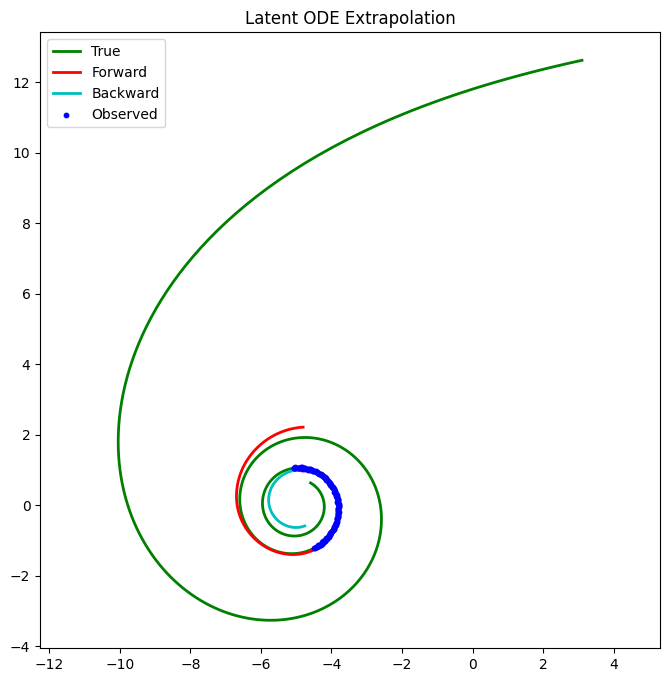

In [8]:
with torch.no_grad():
    # Encode first trajectory
    h = rec.initHidden().to(device)
    for t in reversed(range(samp_trajs.size(1))):
        obs = samp_trajs[:, t, :]
        out, h = rec.forward(obs, h)
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(0.5 * qz0_logvar) + qz0_mean
    
    # Take first trajectory for visualization
    z0 = z0[0]
    
    # Integrate forward and backward
    ts_pos = np.linspace(0., 2.*np.pi, num=2000)
    ts_neg = np.linspace(-np.pi, 0., num=2000)[::-1].copy()
    ts_pos = torch.from_numpy(ts_pos).float().to(device)
    ts_neg = torch.from_numpy(ts_neg).float().to(device)
    
    zs_pos = odeint(func, z0, ts_pos)
    zs_neg = odeint(func, z0, ts_neg)
    
    xs_pos = dec(zs_pos)
    xs_neg = torch.flip(dec(zs_neg), dims=[0])

# Plot
xs_pos = xs_pos.cpu().numpy()
xs_neg = xs_neg.cpu().numpy()
orig_traj = orig_trajs[0].cpu().numpy()
samp_traj = samp_trajs[0].cpu().numpy()

plt.figure(figsize=(8, 8))
plt.plot(orig_traj[:, 0], orig_traj[:, 1], 'g-', label='True', linewidth=2)
plt.plot(xs_pos[:, 0], xs_pos[:, 1], 'r-', label='Forward', linewidth=2)
plt.plot(xs_neg[:, 0], xs_neg[:, 1], 'c-', label='Backward', linewidth=2)
plt.scatter(samp_traj[:, 0], samp_traj[:, 1], s=10, c='blue', label='Observed', zorder=5)
plt.legend()
plt.axis('equal')
plt.title('Latent ODE Extrapolation')
plt.savefig('figs/latent_ode_vis.png', dpi=150, bbox_inches='tight')
plt.show()

## Multiple Examples

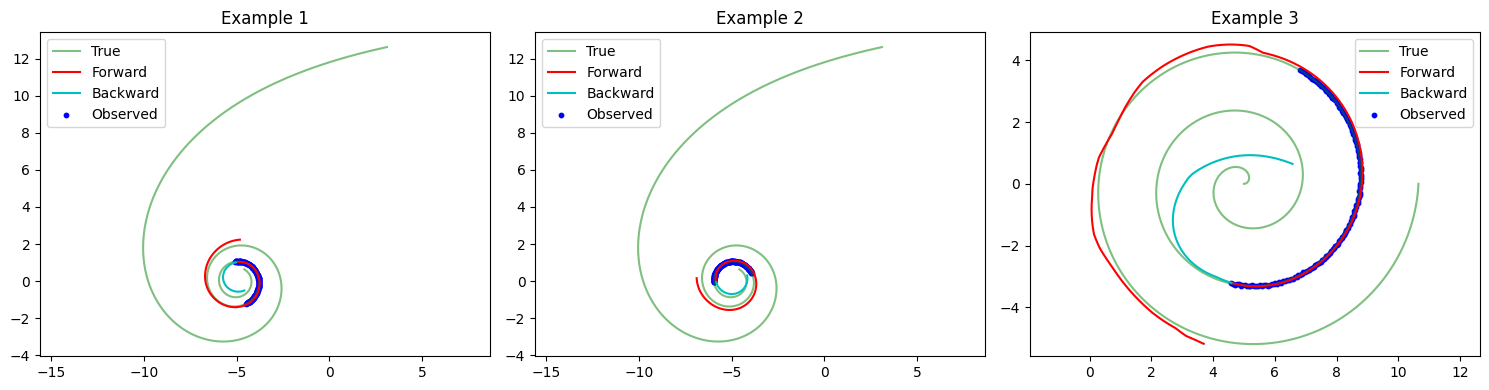

In [9]:
with torch.no_grad():
    # Encode all trajectories
    h = rec.initHidden().to(device)
    for t in reversed(range(samp_trajs.size(1))):
        obs = samp_trajs[:, t, :]
        out, h = rec.forward(obs, h)
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0_all = epsilon * torch.exp(0.5 * qz0_logvar) + qz0_mean
    
    # Visualize first 3
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    for i, ax in enumerate(axes):
        z0 = z0_all[i]
        
        ts_pos = np.linspace(0., 2.*np.pi, num=2000)
        ts_neg = np.linspace(-np.pi, 0., num=2000)[::-1].copy()
        ts_pos = torch.from_numpy(ts_pos).float().to(device)
        ts_neg = torch.from_numpy(ts_neg).float().to(device)
        
        zs_pos = odeint(func, z0, ts_pos)
        zs_neg = odeint(func, z0, ts_neg)
        
        xs_pos = dec(zs_pos).cpu().numpy()
        xs_neg = torch.flip(dec(zs_neg), dims=[0]).cpu().numpy()
        
        orig_traj = orig_trajs[i].cpu().numpy()
        samp_traj = samp_trajs[i].cpu().numpy()
        
        ax.plot(orig_traj[:, 0], orig_traj[:, 1], 'g-', label='True', alpha=0.5)
        ax.plot(xs_pos[:, 0], xs_pos[:, 1], 'r-', label='Forward')
        ax.plot(xs_neg[:, 0], xs_neg[:, 1], 'c-', label='Backward')
        ax.scatter(samp_traj[:, 0], samp_traj[:, 1], s=10, c='blue', label='Observed')
        ax.set_title(f'Example {i+1}')
        ax.legend()
        ax.axis('equal')
    
    plt.tight_layout()
    plt.savefig('figs/latent_ode_extrapolation.png', dpi=150, bbox_inches='tight')
    plt.show()

## Predictions on Sample Window

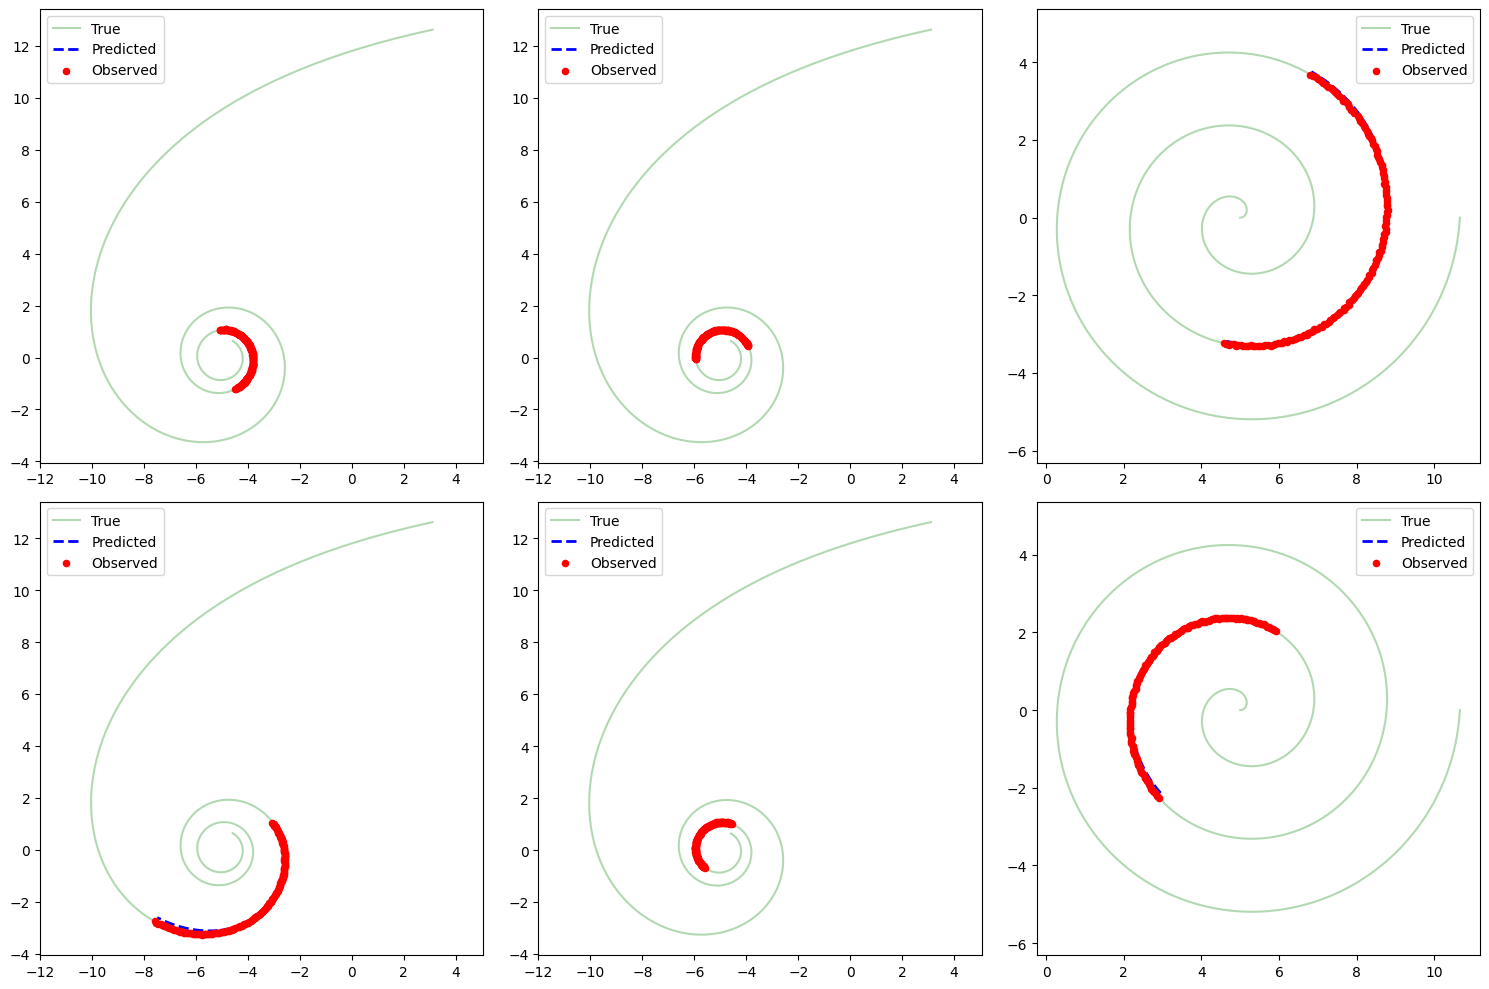

In [10]:
with torch.no_grad():
    # Get predictions for sample times
    h = rec.initHidden().to(device)
    for t in reversed(range(samp_trajs.size(1))):
        obs = samp_trajs[:, t, :]
        out, h = rec.forward(obs, h)
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0_all = epsilon * torch.exp(0.5 * qz0_logvar) + qz0_mean
    
    pred_z = odeint(func, z0_all, samp_ts).permute(1, 0, 2)
    pred_x = dec(pred_z)
    
    # Plot first 6 examples
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        orig_traj = orig_trajs[i].cpu().numpy()
        samp_traj = samp_trajs[i].cpu().numpy()
        pred_traj = pred_x[i].cpu().numpy()
        
        ax.plot(orig_traj[:, 0], orig_traj[:, 1], 'g-', alpha=0.3, label='True')
        ax.plot(pred_traj[:, 0], pred_traj[:, 1], 'b--', label='Predicted', linewidth=2)
        ax.scatter(samp_traj[:, 0], samp_traj[:, 1], s=20, c='red', label='Observed', zorder=5)
        ax.axis('equal')
        ax.legend()
    
    plt.tight_layout()
    plt.savefig('figs/latent_ode_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()